# Trabajo Práctico 3: Detectando atributos de personas.

## Integrantes: Cravero, Ulises y Pautasso, L. Nicolás.
## Tema: CS:GO Professional Matches.

### Imports y configs

In [2]:
# un poco menos de warnings de tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

# lib para trabajar con arrays
import numpy as np

# lib que usamos para mostrar las imágenes
import matplotlib.pyplot as plt

# libs que usamos para construir y entrenar redes neuronales, y que además tiene utilidades para leer sets de imágenes
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG19
from keras.applications.inception_v3 import InceptionV3

#import para la matriz de confusion
import seaborn as sns

# libs que usamos para tareas generales de machine learning. En este caso, métricas
from sklearn.metrics import accuracy_score, confusion_matrix

# configuración para que las imágenes se vean dentro del notebook
%matplotlib inline

# para descargar los datasets desde kaggle
import opendatasets as od

# para dividir el dataset
import os
import shutil
import pandas as pd
import random
import time

### Descarga de datos

#### Descargamos el dataset desde Kaggle:

In [ ]:
# descargamos el dataset correspondiente desde Kaggle
od.download("https://www.kaggle.com/datasets/jessicali9530/celeba-dataset")

#### Fusionamos los datasets que nos serviran para identificar a que conjunto pertenece cada registro y si representa una imagen con barba o no

In [3]:
# cargamos ambos datasets
list_partition = pd.read_csv("./celeba-dataset/list_eval_partition.csv")
list_attribs = pd.read_csv("./celeba-dataset/list_attr_celeba.csv")

# merge en base a la columna 'image_id'
list_partition_and_attribs = pd.merge(list_partition, list_attribs[['image_id', 'No_Beard']], on='image_id', how='inner')

# formateamos
list_partition_and_attribs.columns = list_partition_and_attribs.columns.str.lower()

# convertimos de -1 y 1 a 0 y 1 (va a ser útil para armar el path despues)
list_partition_and_attribs['no_beard'] = np.where(list_partition_and_attribs['no_beard'] == 1, 1, 0)

list_partition_and_attribs.sample(3)

,image_id,partition,no_beard
94546,094547.jpg,0,1
155747,155748.jpg,0,1
18357,018358.jpg,0,1


#### Dividimos las imágenes en directorios dependiendo a que conjunto de datos pertenece

In [4]:
# variables auxiliares para crear los directorios
partitions_names = ['train', 'validation', 'test']
group_names = ['yes_beard', 'no_beard']
# rutas de los directorios que contienen las imágenes
directorios = ['./partitions/train', './partitions/validation', './partitions/test']

In [6]:
# ruta del directorio donde se descargaron las imágenes
directory = "./celeba-dataset/img_align_celeba/img_align_celeba"

# creamos las carpetas de destino
output_directory = "./partitions"
os.makedirs(output_directory, exist_ok=True)

# filtramos y movemos las imágenes a las carpetas correspondientes 
# (partitions_name[0] = train, partitions_name[1] = validation y partitions_name[2] = test)
# (groups_name[0] = yes_beard y groups_name[1] = no_beard)
for index, row in list_partition_and_attribs.iterrows():
    image_id = row['image_id']
    partition = row['partition']
    attribute = row['no_beard']
    source_path = os.path.join(directory, f"{image_id}")
    destination_path = os.path.join(output_directory, partitions_names[partition], group_names[attribute], f"{image_id}")
    os.makedirs(os.path.dirname(destination_path), exist_ok=True)
    shutil.copyfile(source_path, destination_path)

### Análisis exploratorio sobre el conjunto de datos

#### Muestreo y caracteristicas de las imágenes:

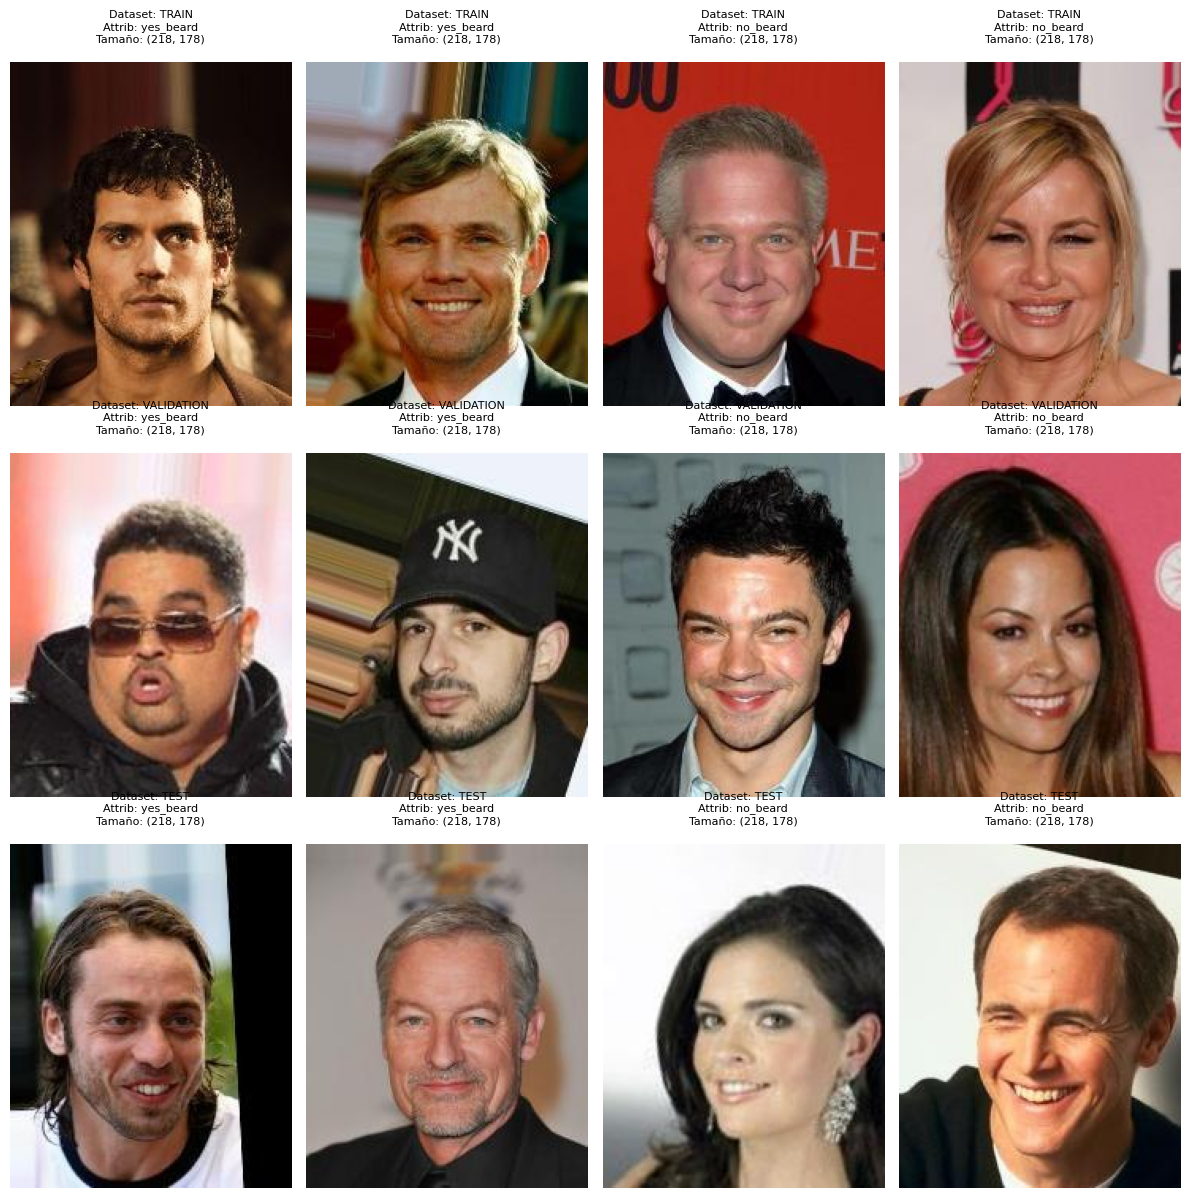

In [5]:
# Mostrar una cuadrícula de 3x4
fig, axs = plt.subplots(3, 4, figsize=(12, 12))

# Iterar sobre los directorios
for i, directorio in enumerate(directorios):
    dir_yes_beard = os.path.join(directorio, group_names[0])
    dir_no_beard = os.path.join(directorio, group_names[1])
    # Elegir cuatro imágenes aleatorias dentro de los subdirectorios
    list_dir_yes_beard = os.listdir(dir_yes_beard)
    list_dir_no_beard = os.listdir(dir_no_beard)
    muestras_yes = random.sample(list_dir_yes_beard, 2)
    muestras_no = random.sample(list_dir_no_beard, 2)
    muestras = muestras_yes + muestras_no
    # Iterar sobre las muestras y mostrar las imágenes
    for j, muestra in enumerate(muestras):
        #nos fijamos a donde pertenece la muestra
        conjunto = group_names[0] if muestra in muestras_yes else group_names[1]
        ruta_imagen = os.path.join(directorio, conjunto, muestra)       
        # Leer la imagen y mostrarla
        img = plt.imread(ruta_imagen)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        # Obtener características de la imagen
        tamano = img.shape[:2]
        formato = muestra.split('.')[-1].upper()
        tipo = img.dtype
        axs[i, j].set_title(f"Dataset: {partitions_names[i].upper()}\nAttrib: {conjunto}\nTamaño: {tamano}\n", fontsize=8)
    
    
# Ajustar el espacio entre las imágenes
plt.tight_layout()

# Mostrar el gráfico con las imágenes
plt.show()

#### Cantidad de imagenes por conjunto, cantidad de imagenes por categoria/conjunto y distribución de la variable de salida ('no_beard') por conjunto:

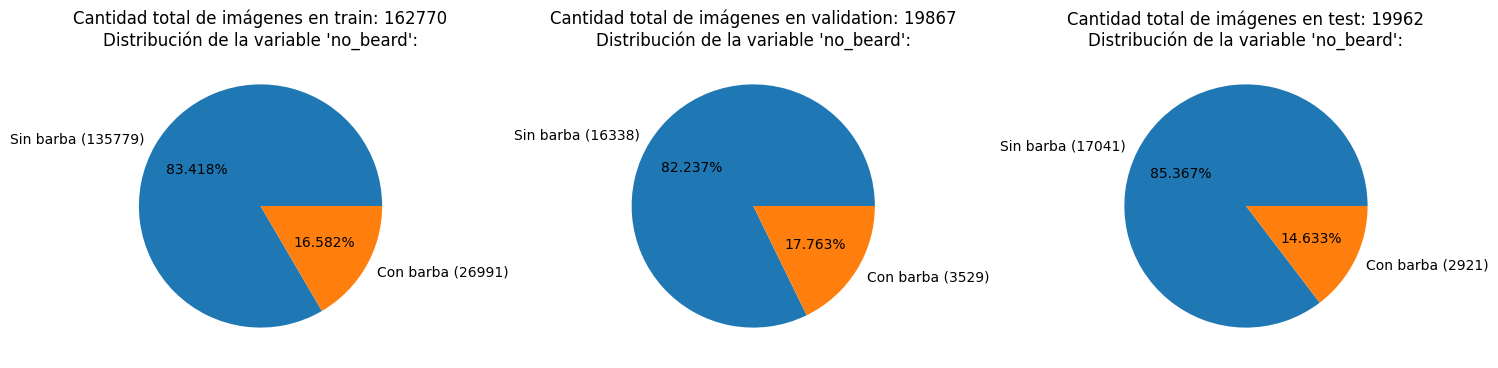

In [7]:
# 1 fila y 3 columnas

fig, axs = plt.subplots(1, 3, figsize=(15, 5))  
for index, _ in enumerate(partitions_names):
    ax = axs[index]
    partition_data = list_partition_and_attribs[list_partition_and_attribs['partition'] == index]
    no_beard = (partition_data['no_beard'] == 1).sum()
    yes_beard = (partition_data['no_beard'] == 0).sum()

    ax.pie([no_beard, yes_beard], labels=[f"Sin barba ({no_beard})", f"Con barba ({yes_beard})"], autopct='%1.3f%%')
    ax.set_title(f"Cantidad total de imágenes en {partitions_names[index]}: {no_beard + yes_beard}\nDistribución de la variable 'no_beard':")

plt.tight_layout()
plt.show()
    

### Machine learning

#### Cargamos las imágenes de cada dataset en variables

In [6]:
# tamaño de procesado
size = 64

train_data = ImageDataGenerator(rescale=1/255)
validation_data = ImageDataGenerator(rescale=1/255)
test_data = ImageDataGenerator(rescale=1/255)

train_set = train_data.flow_from_directory(directorios[0], target_size=(size, size), class_mode='binary')
validation_set = validation_data.flow_from_directory(directorios[1], target_size=(size, size), class_mode='binary')
test_set = test_data.flow_from_directory(directorios[2], target_size=(size, size), class_mode='binary')


Found 162770 images belonging to 2 classes.
Found 19867 images belonging to 2 classes.
Found 19962 images belonging to 2 classes.


#### Visualizamos algunos ejemplos a modo de ver la forma que tendran las imagenes al procesarlas

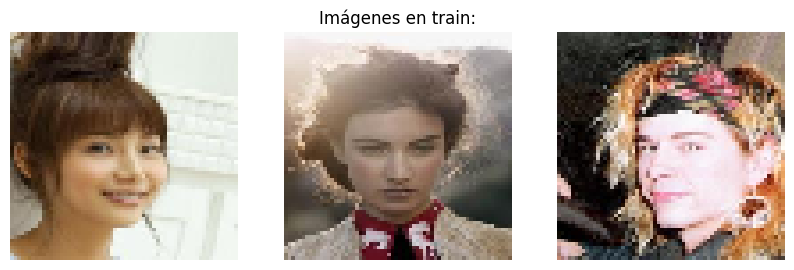

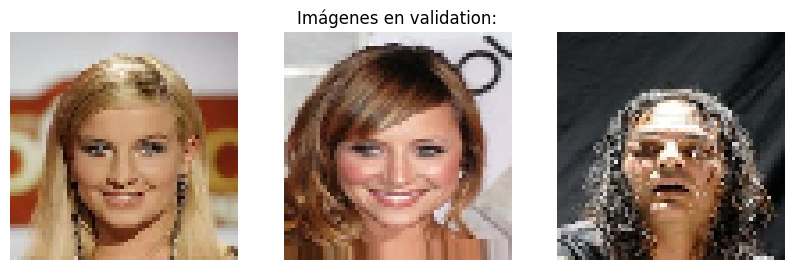

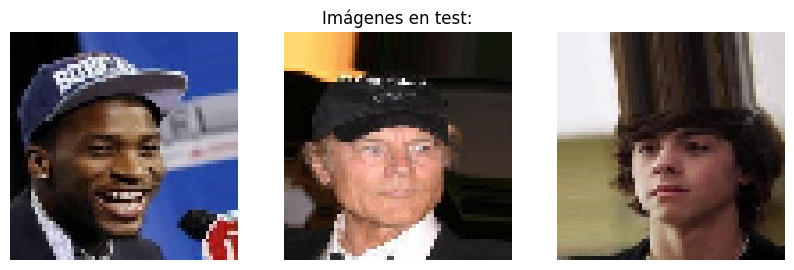

In [6]:
def sample_images(dataset, titulo):
    plt.figure(figsize=(10, 10))
    images, labels = dataset.next()
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i])
        plt.title(titulo) if i == 1 else plt.title('')
        plt.axis("off")
    
sample_images(train_set, 'Imágenes en train:')
sample_images(validation_set, 'Imágenes en validation:')
sample_images(test_set, 'Imágenes en test:')

#### Inicializamos los modelos a entrenar

In [7]:
# el shape de los inputs es alto_imagen * ancho_imagen * cantidad_colores
input_shape = (size, size, 3)

# instanciamos el callback
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

#### MLP simple

In [12]:
model_mlp = Sequential([
    Flatten(input_shape=input_shape),
    Dense(200, activation ="relu"),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

model_mlp.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model_mlp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 12288)             0         
                                                                 
 dense_4 (Dense)             (None, 200)               2457800   
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 201       
                                                                 
Total params: 2458001 (9.38 MB)
Trainable params: 2458001 (9.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
history_mlp = model_mlp.fit(
    train_set,
    epochs=10,
    batch_size=1500,
    validation_data=validation_set,
    callbacks=[OurCustomCallback()]
)

Epoch 1/10
5087/5087 [==============================] - 91s 18ms/step - loss: 0.3540 - accuracy: 0.8399 - val_loss: 0.3009 - val_accuracy: 0.8366
Epoch 2/10
5087/5087 [==============================] - 93s 18ms/step - loss: 0.2996 - accuracy: 0.8655 - val_loss: 0.2533 - val_accuracy: 0.8943
Epoch 3/10
5087/5087 [==============================] - 93s 18ms/step - loss: 0.2775 - accuracy: 0.8774 - val_loss: 0.2445 - val_accuracy: 0.8968
Epoch 4/10
5087/5087 [==============================] - 93s 18ms/step - loss: 0.2698 - accuracy: 0.8803 - val_loss: 0.2794 - val_accuracy: 0.8705
Epoch 5/10
5087/5087 [==============================] - 91s 18ms/step - loss: 0.2608 - accuracy: 0.8838 - val_loss: 0.2240 - val_accuracy: 0.9080
Epoch 6/10
5087/5087 [==============================] - 91s 18ms/step - loss: 0.2589 - accuracy: 0.8847 - val_loss: 0.2373 - val_accuracy: 0.9011
Epoch 7/10
5087/5087 [==============================] - 93s 18ms/step - loss: 0.2543 - accuracy: 0.8866 - val_loss: 0.2233 -

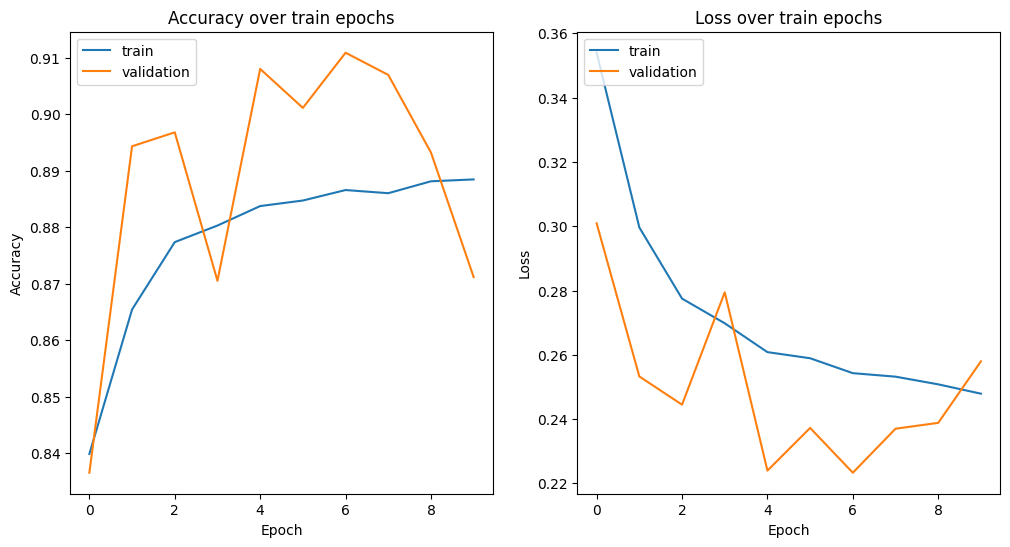

In [20]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history_mlp.history['accuracy'], label='train')
plt.plot(history_mlp.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.subplot(1,2,2)
plt.plot(history_mlp.history['loss'], label='train')
plt.plot(history_mlp.history['val_loss'], label='validation')
plt.title('Loss over train epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

624/624 [==============================] - 6s 10ms/step


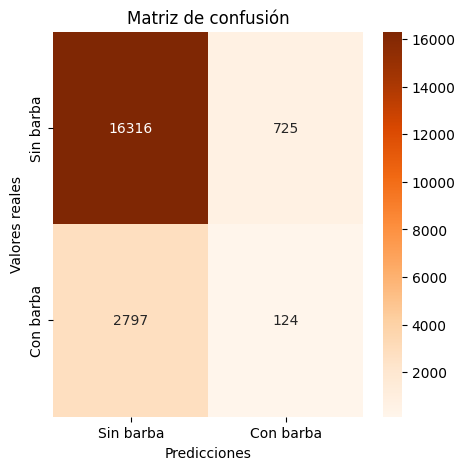

In [21]:
predictions_mlp = model_mlp.predict(test_set)
predictions_mlp = np.round(predictions_mlp).flatten()

cm = confusion_matrix(test_set.labels, predictions_mlp)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap='Oranges', fmt='d',  xticklabels=['Sin barba', 'Con barba'], yticklabels=['Sin barba', 'Con barba'])
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión')
plt.show()

##### Se realizaron pruebas modificando diversos parámetros, como por ejemplo el metodo de activación fue cambiado por 'tanh' y sin Dropout, obtendiendo resultados con menor accuracy que el modelo descripto arriba (con activación = 'relu' y dropout = 0.25'). De todas maneras, podemos ver que el val_accuracy siempre se encuentra por arriba del accuracy sobre train, por lo que el modelo estaría overfitteando.

#### Convolucional

In [45]:
model_conv = Sequential([
    Convolution2D(input_shape=input_shape, filters=15, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    Convolution2D(filters=15, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),

    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(10, activation='tanh'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

model_conv.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model_conv.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_96 (Conv2D)          (None, 61, 61, 15)        735       
                                                                 
 dropout_8 (Dropout)         (None, 61, 61, 15)        0         
                                                                 
 conv2d_97 (Conv2D)          (None, 58, 58, 15)        3615      
                                                                 
 dropout_9 (Dropout)         (None, 58, 58, 15)        0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 15)        0         
 g2D)                                                            
                                                                 
 flatten_6 (Flatten)         (None, 2940)              0         
                                                      

In [46]:
history_conv = model_conv.fit(
    train_set,
    epochs=10,
    batch_size=1500,
    validation_data=validation_set,
    callbacks=[OurCustomCallback()]
)

Epoch 1/10
5087/5087 [==============================] - 244s 48ms/step - loss: 0.2533 - accuracy: 0.8949 - val_loss: 0.2151 - val_accuracy: 0.9075
Epoch 2/10
5087/5087 [==============================] - 239s 47ms/step - loss: 0.2071 - accuracy: 0.9157 - val_loss: 0.1854 - val_accuracy: 0.9243
Epoch 3/10
5087/5087 [==============================] - 235s 46ms/step - loss: 0.1976 - accuracy: 0.9186 - val_loss: 0.1890 - val_accuracy: 0.9226
Epoch 4/10
5087/5087 [==============================] - 244s 48ms/step - loss: 0.1950 - accuracy: 0.9206 - val_loss: 0.1787 - val_accuracy: 0.9267
Epoch 5/10
5087/5087 [==============================] - 248s 49ms/step - loss: 0.1901 - accuracy: 0.9226 - val_loss: 0.1704 - val_accuracy: 0.9314
Epoch 6/10
5087/5087 [==============================] - 244s 48ms/step - loss: 0.1891 - accuracy: 0.9230 - val_loss: 0.1659 - val_accuracy: 0.9308
Epoch 7/10
5087/5087 [==============================] - 244s 48ms/step - loss: 0.1862 - accuracy: 0.9243 - val_loss: 0

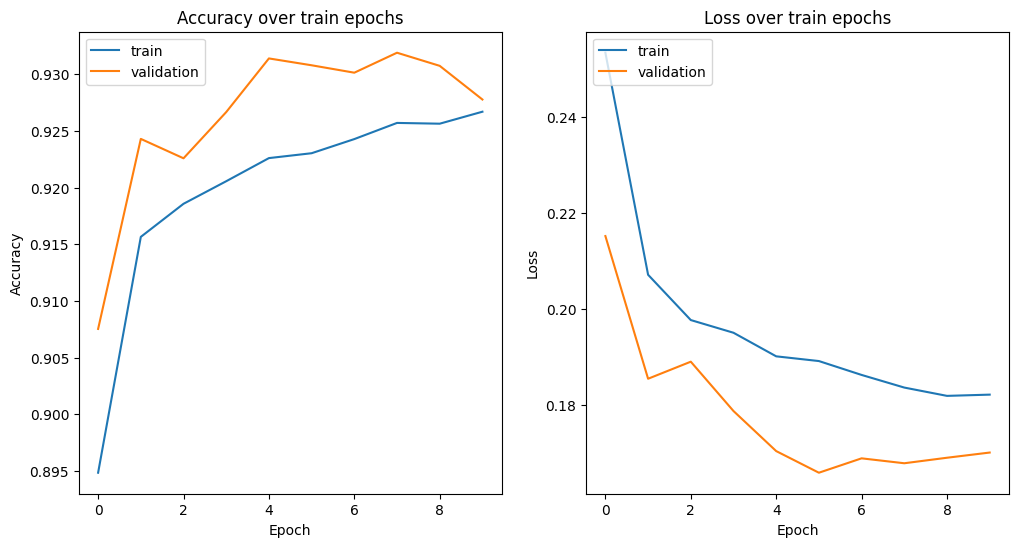

In [47]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history_conv.history['accuracy'], label='train')
plt.plot(history_conv.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.subplot(1,2,2)
plt.plot(history_conv.history['loss'], label='train')
plt.plot(history_conv.history['val_loss'], label='validation')
plt.title('Loss over train epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [8]:
model_conv2 = Sequential([
    Convolution2D(input_shape=input_shape, filters=15, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),

    Convolution2D(filters=15, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),

    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(300, activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

model_conv2.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model_conv2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 15)        735       
                                                                 
 dropout (Dropout)           (None, 61, 61, 15)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 15)        3615      
                                                                 
 dropout_1 (Dropout)         (None, 58, 58, 15)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 15)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 2940)              0         
                                                        

In [9]:
history_conv2 = model_conv2.fit(
    train_set,
    epochs=10,
    batch_size=1500,
    validation_data=validation_set,
    callbacks=[OurCustomCallback()]
)

Epoch 1/10
5087/5087 [==============================] - 256s 50ms/step - loss: 0.2402 - accuracy: 0.8980 - val_loss: 0.1894 - val_accuracy: 0.9196
Epoch 2/10
5087/5087 [==============================] - 274s 54ms/step - loss: 0.1943 - accuracy: 0.9181 - val_loss: 0.1835 - val_accuracy: 0.9217
Epoch 3/10
5087/5087 [==============================] - 272s 54ms/step - loss: 0.1826 - accuracy: 0.9240 - val_loss: 0.1719 - val_accuracy: 0.9288
Epoch 4/10
5087/5087 [==============================] - 257s 51ms/step - loss: 0.1760 - accuracy: 0.9260 - val_loss: 0.1677 - val_accuracy: 0.9281
Epoch 5/10
5087/5087 [==============================] - 265s 52ms/step - loss: 0.1697 - accuracy: 0.9289 - val_loss: 0.1726 - val_accuracy: 0.9282
Epoch 6/10
5087/5087 [==============================] - 259s 51ms/step - loss: 0.1645 - accuracy: 0.9308 - val_loss: 0.1793 - val_accuracy: 0.9253
Epoch 7/10
5087/5087 [==============================] - 253s 50ms/step - loss: 0.1590 - accuracy: 0.9336 - val_loss: 0

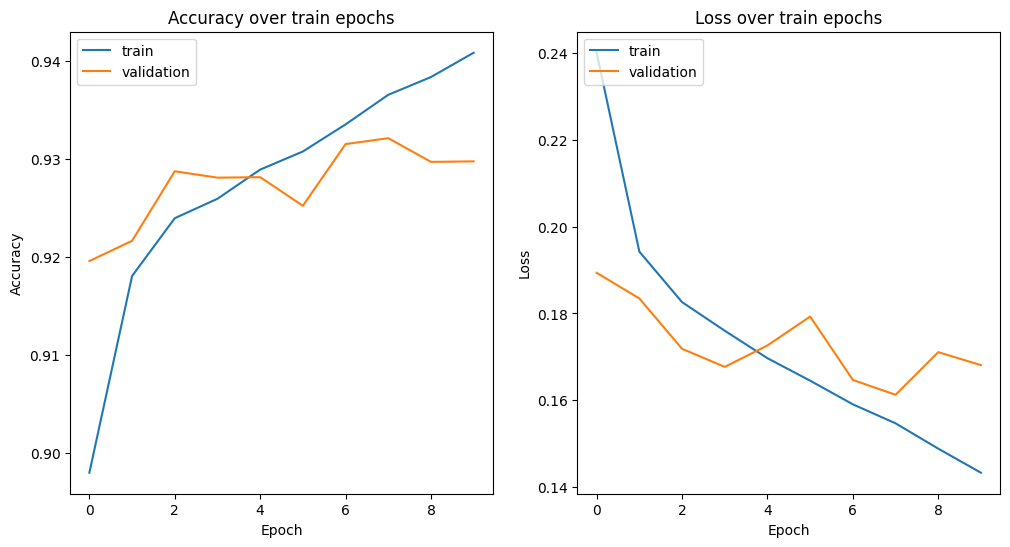

In [10]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(history_conv2.history['accuracy'], label='train')
plt.plot(history_conv2.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.subplot(1,2,2)
plt.plot(history_conv2.history['loss'], label='train')
plt.plot(history_conv2.history['val_loss'], label='validation')
plt.title('Loss over train epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

624/624 [==============================] - 10s 16ms/step


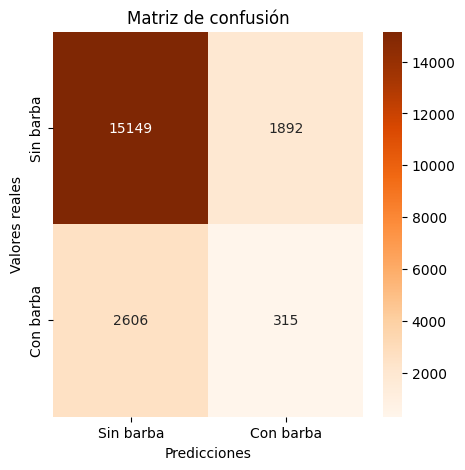

In [13]:
predictions_conv = model_conv2.predict(test_set)
predictions_conv = np.round(predictions_conv).flatten()

cm = confusion_matrix(test_set.labels, predictions_conv)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap='Oranges', fmt='d',  xticklabels=['Sin barba', 'Con barba'], yticklabels=['Sin barba', 'Con barba'])
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión')
plt.show()

##### Se corrieron sucesivos modelos del mismo tipo, quitando la capa de MaxPooling y se obtuvieron resultados similares, tanto en accuracy como val_accuracy. Luego se probó elevando el porcentaje de Dropout a 0.50 y podiamos ver que el modelo se estancaba en un valor constante de accuracy. Finalmente pudimos obtener una mejora en la accuracy del modelo elevando la cantidad de neuronas en la capa densa (de 10 a 300 neuronas), permiendo que aprenda mas caracteristicas. Asi el val_acuraccy ahora se encuentra por debajo del accuracy en train, por lo que se podría pensar que el modelo ya no esta overfitteando.

#### Convolucional usando convoluciones ya entrenadas de VGG19

In [49]:
pretrained_model = VGG19(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model_conv_fitted = Sequential([
    pretrained_model,

    Flatten(),

    Dense(250 , activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

model_conv_fitted.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model_conv_fitted.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten_11 (Flatten)        (None, 2048)              0         
                                                                 
 dense_23 (Dense)            (None, 250)               512250    
                                                                 
 dropout_8 (Dropout)         (None, 250)               0         
                                                                 
 dense_24 (Dense)            (None, 1)                 251       
                                                                 
Total params: 20536885 (78.34 MB)
Trainable params: 512501 (1.96 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [51]:
history_conv_fitted = model_conv_fitted.fit(
    train_set,
    epochs=10,
    batch_size=50000,
    validation_data=validation_set,
    callbacks=[OurCustomCallback()]
)

Epoch 1/10
5087/5087 [==============================] - 1551s 305ms/step - loss: 0.3330 - accuracy: 0.8460 - val_loss: 0.3322 - val_accuracy: 0.8449
Epoch 2/10
5087/5087 [==============================] - 1577s 310ms/step - loss: 0.3251 - accuracy: 0.8493 - val_loss: 0.3345 - val_accuracy: 0.8440
Epoch 3/10
5087/5087 [==============================] - 1591s 313ms/step - loss: 0.3210 - accuracy: 0.8511 - val_loss: 0.3315 - val_accuracy: 0.8435
Epoch 4/10
5087/5087 [==============================] - 1599s 314ms/step - loss: 0.3169 - accuracy: 0.8523 - val_loss: 0.3263 - val_accuracy: 0.8473
Epoch 5/10
5087/5087 [==============================] - 1968s 387ms/step - loss: 0.3138 - accuracy: 0.8538 - val_loss: 0.3284 - val_accuracy: 0.8479
Epoch 6/10
5087/5087 [==============================] - 2749s 541ms/step - loss: 0.3109 - accuracy: 0.8546 - val_loss: 0.3215 - val_accuracy: 0.8508
Epoch 7/10
5087/5087 [==============================] - 2109s 415ms/step - loss: 0.3082 - accuracy: 0.8568

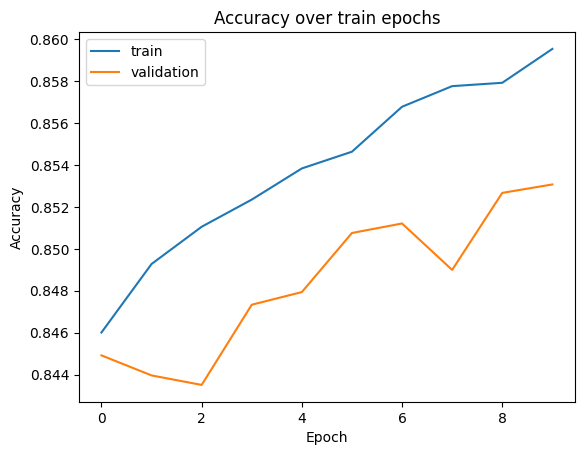

In [52]:
plt.plot(history_conv_fitted.history['accuracy'], label='train')
plt.plot(history_conv_fitted.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

##### Viendo la grafica anterior, la tendencia de la accuracy en train nos da a pensar que si seguimos entrenando el modelo a lo largo de mas epocas, la precision de su predicción seguira aumentando. Para intentar corrobar nuestra teoria, entrenamos el modelo durante mayor cantidad de epocas (20)

##### Entrenamos la red neuronal con mas cantidad de épocas

In [25]:
pretrained_model = VGG19(input_shape=input_shape, include_top=False)
pretrained_model.trainable = False

model_conv_fitted_more_epochs = Sequential([
    pretrained_model,

    Flatten(),

    Dense(250 , activation='relu'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

model_conv_fitted_more_epochs.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model_conv_fitted_more_epochs.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 250)               512250    
                                                                 
 dropout_3 (Dropout)         (None, 250)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 251       
                                                                 
Total params: 20536885 (78.34 MB)
Trainable params: 512501 (1.96 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [26]:
model_conv_fitted_more_epochs = model_conv_fitted_more_epochs.fit(
    train_set,
    epochs=20,
    batch_size=1500,
    validation_data=validation_set,
    callbacks=[OurCustomCallback()]
)

Epoch 1/20
5087/5087 [==============================] - 1556s 306ms/step - loss: 0.3463 - accuracy: 0.8408 - val_loss: 0.3338 - val_accuracy: 0.8449
Epoch 2/20
5087/5087 [==============================] - 1534s 302ms/step - loss: 0.3287 - accuracy: 0.8483 - val_loss: 0.3296 - val_accuracy: 0.8457
Epoch 3/20
5087/5087 [==============================] - 1525s 300ms/step - loss: 0.3230 - accuracy: 0.8506 - val_loss: 0.3274 - val_accuracy: 0.8483
Epoch 4/20
5087/5087 [==============================] - 1526s 300ms/step - loss: 0.3180 - accuracy: 0.8522 - val_loss: 0.3417 - val_accuracy: 0.8466
Epoch 5/20
5087/5087 [==============================] - 1525s 300ms/step - loss: 0.3140 - accuracy: 0.8547 - val_loss: 0.3230 - val_accuracy: 0.8487
Epoch 6/20
5087/5087 [==============================] - 1526s 300ms/step - loss: 0.3115 - accuracy: 0.8559 - val_loss: 0.3270 - val_accuracy: 0.8453
Epoch 7/20
5087/5087 [==============================] - 1526s 300ms/step - loss: 0.3087 - accuracy: 0.8566

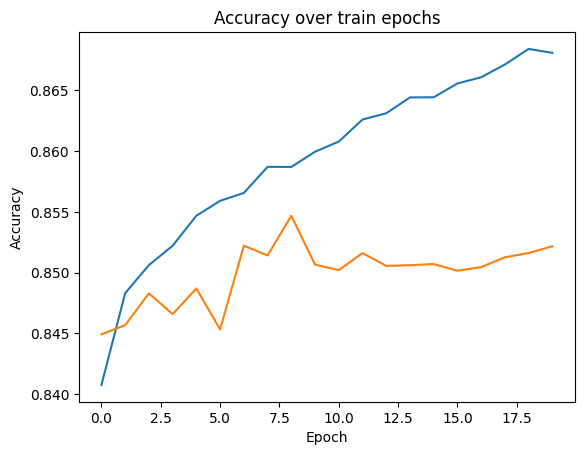

In [29]:
plt.plot(model_conv_fitted_more_epochs.history['accuracy'], label='train')
plt.plot(model_conv_fitted_more_epochs.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

##### Luego del entrenamiento a lo largo de las 20 epocas, vemos que el nivel de accuracy aumenta, por lo que confirmamos la hipotesis anterior.

#### Probamos con InceptionV3

In [44]:
pretrained_model_inception = InceptionV3(weights = 'imagenet', include_top = False, input_shape=input_shape)
pretrained_model_inception.trainable = False

model_conv_inception = Sequential([
    pretrained_model_inception,

    Flatten(),

    Dense(300, activation='relu'),
    Dropout(0.50),
    
    Dense(1, activation='sigmoid'),
])

model_conv_inception.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)


model_conv_inception.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 300)               614700    
                                                                 
 dropout_7 (Dropout)         (None, 300)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 301       
                                                                 
Total params: 22417785 (85.52 MB)
Trainable params: 615001 (2.35 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [15]:
history_conv_inception = model_conv_inception.fit(
    train_set,
    epochs=10,
    batch_size=1500,
    validation_data=validation_set,
    callbacks=[OurCustomCallback()]
)

Epoch 1/10
5087/5087 [==============================] - 308s 60ms/step - loss: 0.2925 - accuracy: 0.8632 - val_loss: 0.3551 - val_accuracy: 0.8391
Epoch 2/10
5087/5087 [==============================] - 301s 59ms/step - loss: 0.2881 - accuracy: 0.8654 - val_loss: 0.3537 - val_accuracy: 0.8353
Epoch 3/10
5087/5087 [==============================] - 300s 59ms/step - loss: 0.2825 - accuracy: 0.8687 - val_loss: 0.3697 - val_accuracy: 0.8380
Epoch 4/10
5087/5087 [==============================] - 304s 60ms/step - loss: 0.2788 - accuracy: 0.8701 - val_loss: 0.3675 - val_accuracy: 0.8362
Epoch 5/10
5087/5087 [==============================] - 295s 58ms/step - loss: 0.2743 - accuracy: 0.8715 - val_loss: 0.3727 - val_accuracy: 0.8374
Epoch 6/10
5087/5087 [==============================] - 306s 60ms/step - loss: 0.2688 - accuracy: 0.8735 - val_loss: 0.3783 - val_accuracy: 0.8362
Epoch 7/10
5087/5087 [==============================] - 340s 67ms/step - loss: 0.2649 - accuracy: 0.8760 - val_loss: 0

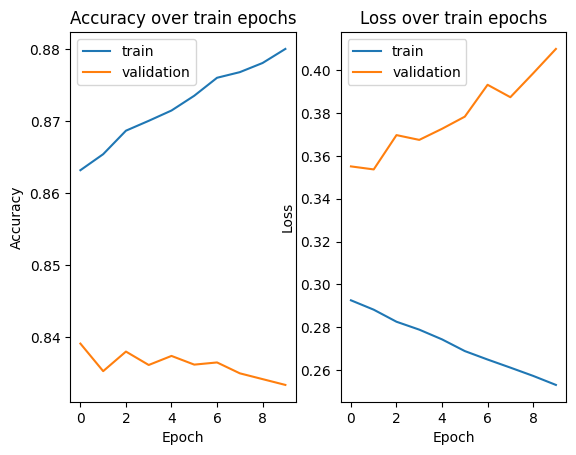

In [16]:
plt.subplot(1,2,1)
plt.plot(history_conv_inception.history['accuracy'], label='train')
plt.plot(history_conv_inception.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.subplot(1,2,2)
plt.plot(history_conv_inception.history['loss'], label='train')
plt.plot(history_conv_inception.history['val_loss'], label='validation')
plt.title('Loss over train epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

##### Como modelo preentrenado extra, encontramos la red InceptionV3 (podemos ver mas información en el siguiente link: https://www.kaggle.com/code/lusfernandotorres/gender-recognition-inceptionv3). Si bien podemos observar los resultados obtenidos son menores o iguales que utilizando VGG19, podemos concluir que el tiempo de entrenamiento necesario se reduce en una quinta parte, por lo que si el factor tiempo es importante a la hora de obtener resultados, seria un modelo feacible de utilizar.

### Aumentación de datos:

In [33]:
images_reader_aum = ImageDataGenerator(
    rescale=1/255,
    rotation_range=50,
    brightness_range=(1, 2),
    horizontal_flip=True
)

train_set_aum = images_reader_aum.flow_from_directory(directorios[0], target_size=(size, size), class_mode='binary')
validation_set_aum = images_reader_aum.flow_from_directory(directorios[1], target_size=(size, size), class_mode='binary')
test_set_aum = images_reader_aum.flow_from_directory(directorios[2], target_size=(size, size), class_mode='binary')

Found 162770 images belonging to 2 classes.
Found 19867 images belonging to 2 classes.
Found 19962 images belonging to 2 classes.


#### Visualizamos algunos ejemplos a modo de ver la forma que tendran las imagenes al procesarlas

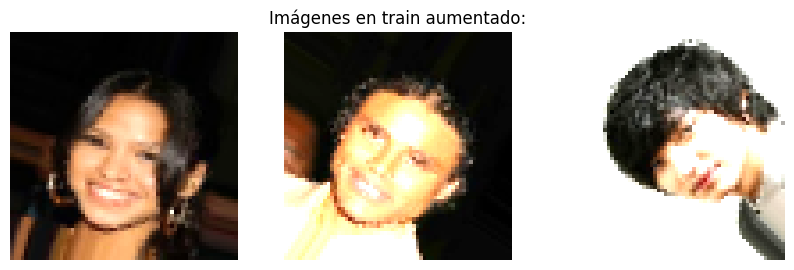

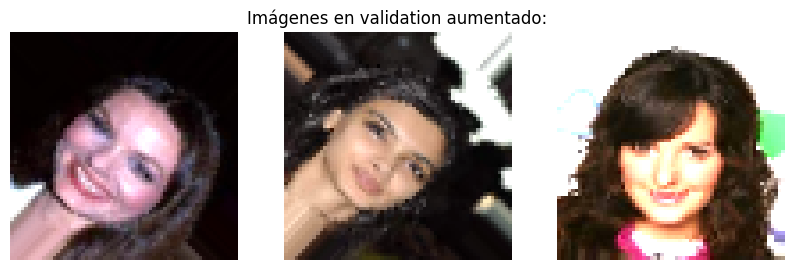

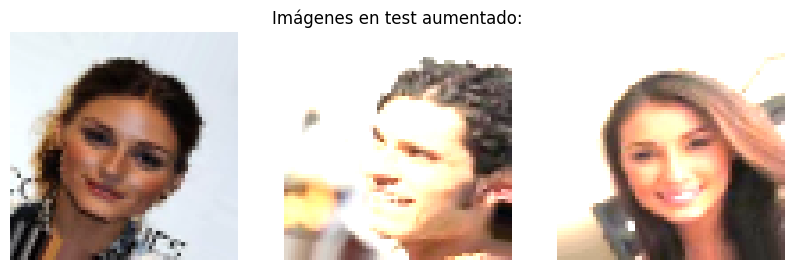

In [34]:
def sample_images(dataset, titulo):
    plt.figure(figsize=(10, 10))
    images, labels = dataset.next()
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(images[i])
        plt.title(titulo) if i == 1 else plt.title('')
        plt.axis("off")
    
sample_images(train_set_aum, 'Imágenes en train aumentado:')
sample_images(validation_set_aum, 'Imágenes en validation aumentado:')
sample_images(test_set_aum, 'Imágenes en test aumentado:')

#### Entrenamos el modelo que mejores resultado habia obtenido (convolucional):

In [35]:
model_conv_aum = Sequential([
    Convolution2D(input_shape=input_shape, filters=15, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    Convolution2D(filters=15, kernel_size=(4, 4), strides=1, activation='relu'),
    Dropout(0.25),
    
    MaxPooling2D(pool_size=(4, 4)),
    
    Flatten(),
    
    Dense(300, activation='tanh'),
    Dropout(0.25),
    
    Dense(1, activation='sigmoid'),
])

model_conv_aum.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

model_conv_aum.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 61, 15)        735       
                                                                 
 dropout_4 (Dropout)         (None, 61, 61, 15)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 15)        3615      
                                                                 
 dropout_5 (Dropout)         (None, 58, 58, 15)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 15)        0         
 D)                                                              
                                                                 
 flatten_4 (Flatten)         (None, 2940)              0         
                                                      

In [41]:
history_conv_aum = model_conv_aum.fit(
    train_set_aum,
    epochs=10,
    batch_size=1500,
    validation_data=validation_set_aum,
    callbacks=[OurCustomCallback()]
)

Epoch 1/10
5087/5087 [==============================] - 265s 52ms/step - loss: 0.2343 - accuracy: 0.9012 - val_loss: 0.2124 - val_accuracy: 0.9112
Epoch 2/10
5087/5087 [==============================] - 278s 55ms/step - loss: 0.2350 - accuracy: 0.9010 - val_loss: 0.2072 - val_accuracy: 0.9151
Epoch 3/10
5087/5087 [==============================] - 269s 53ms/step - loss: 0.2347 - accuracy: 0.9017 - val_loss: 0.2154 - val_accuracy: 0.9117
Epoch 4/10
5087/5087 [==============================] - 275s 54ms/step - loss: 0.2341 - accuracy: 0.9020 - val_loss: 0.2126 - val_accuracy: 0.9104
Epoch 5/10
5087/5087 [==============================] - 266s 52ms/step - loss: 0.2352 - accuracy: 0.9006 - val_loss: 0.2100 - val_accuracy: 0.9131
Epoch 6/10
5087/5087 [==============================] - 276s 54ms/step - loss: 0.2347 - accuracy: 0.9014 - val_loss: 0.2150 - val_accuracy: 0.9111
Epoch 7/10
5087/5087 [==============================] - 274s 54ms/step - loss: 0.2340 - accuracy: 0.9013 - val_loss: 0

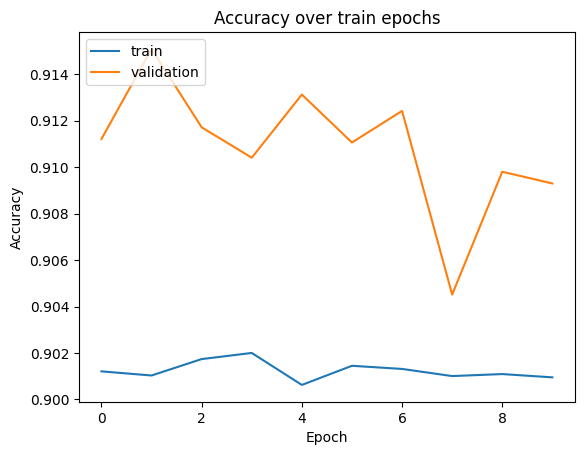

In [42]:
plt.plot(history_conv_aum.history['accuracy'], label='train')
plt.plot(history_conv_aum.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

624/624 [==============================] - 10s 15ms/step


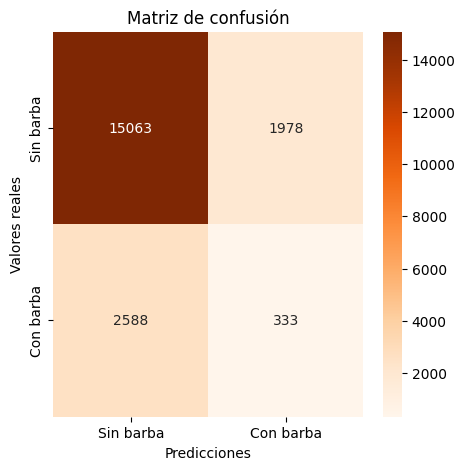

In [43]:
predictions_conv_aum = model_conv_aum.predict(test_set)
predictions_conv_aum = np.round(predictions_conv_aum).flatten()

cm = confusion_matrix(test_set.labels, predictions_conv_aum)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, cmap='Oranges', fmt='d',  xticklabels=['Sin barba', 'Con barba'], yticklabels=['Sin barba', 'Con barba'])
plt.xlabel('Predicciones')
plt.ylabel('Valores reales')
plt.title('Matriz de confusión')
plt.show()

##### Al realizar la aumentación de datos sobre el modelo que mejor accuracy obtuvo, podemos ver en la gráfica anterior que el mismo reduce su performance en cuanto a la métrica. También percibimos que no se observa un crecimiento en el entrenamiento a medida que transcurren las épocas.